# INTRODUÇÃO À BIBLIOTECA

Essa biblioteca objetiva efetuar a estimativa computacional da propagação de feixes ópticos para equações paraxiais de onda em (2 + 1) dimensões,
$$
    \imath\partial_zA(x,y)= \left[\frac{1}{2\kappa}\nabla_\perp^2 + \mathcal{N}(A(x,y))\right]A(x,y)\text{,}
$$
com base no perfil inicial do feixe ($A_{z = 0}(x,y)$).

In [1]:
# muda o diretório para onde está optical/
%cd -q ../../

## CONSTRUÇÃO DE PERFIS INICIAIS GENÉRICOS

A utilização mais fundamental desta biblioteca de módulos `python` é a computação dos perfis iniciais do feixe óptico que deseja-se propagar ao longo de meios ópticos. Para isso, utilizamos o módulo `optical.beam`.

> `optical.beam.create(F = lambda x,y: A(x,y), region = (X,Y))`
>
> > computa o feixe de envoltória $A(x,y)$ nos pontos de `(X,Y)` como uma `numpy.ndarray` (matriz bidimensional) de entradas complexas (`np.complex128`).
>
> parâmetros opcionais:
> 
> > `center = (x0, y0)`
> >
> > par de coordenadas do centro do feixe.
>
> > `phase`
> >
> > valor da fase como número, matriz bidimensional ou função das coordenadas `(X, Y)`
> > em `region`.
>
> > `k = optical.wave_vector(k, angulation = (phi_x, phi_y))`
> >
> > vetor de onda incidente de intensidade `k` = $2\pi/\lambda$ e com angulação `angulation`.
>
> > `coordinate_system`
> >
> > sistema de coordenadas do plano transversal em que `F` é descrito.
> > > - coordenadas cartesianas: `optical.coordinate.cartesian`;
> > > - coordenadas polares: `optical.coordinate.polar`;
>


In [2]:
# módulo optical.beam: construtores de perfis iniciais
from optical import beam
# construtores auxiliares da biblioteca optical
from optical import wave_vector, coordinate

# módulo numpy: computação geral de matrizes
import numpy as np                  # importa numpy como "np"

# construção da partição dos eixos do plano transversal
x = np.linspace(-40.,+40.,500);     # particiona (-40,+40) em 500
y = np.linspace(-40.,+40.,500);     # particiona (-40,+40) em 500

# construção da malha de pontos
X, Y = np.meshgrid(x, y);           # malha de pontos do plano

# construção de feixe óptico genérico
A = beam.create(
    F = lambda r, _: np.exp(-(r / 20.) ** 2.) * np.cos(r),
    region = (X, Y),
    phase = lambda r, theta: np.pi * r ** 2 * np.cos(theta),
    k = wave_vector(k = 1.0, angulation = (0., 45.)),
    coordinate_system = coordinate.polar
);

A biblioteca `optical.beam` conta com o método `optical.beam.normalize(U)` que retorna o campo com intensidade máxima unitária caso seja necessário.

### PERFIL TRANSVERSAL DO FEIXE ÓPTICO

Com o feixe computado podemos construir gráficos de sua intensidade $|A(x,y)|^2$ e fase $\operatorname{arg}(A(x,y))$ utilizando o módulo `matplotlib.pyplot`.

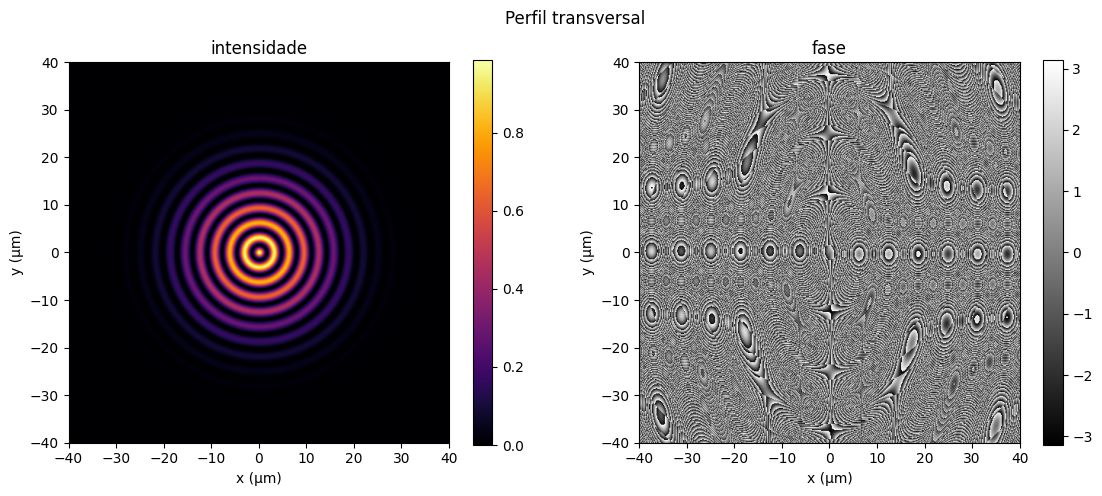

In [3]:
# módulo matplotlib.pyplot: construção de representações gráficas
import matplotlib.pyplot as plt     # importa pyplot como "plt"

# exibe as imagens geradas em linha
%matplotlib inline

# cria a figura com dois subplots de tamanho (13.5, 5.0) em inches
fig, ax = plt.subplots(1, 2, figsize = (13.5, 5.0));
fig.suptitle('Perfil transversal')

# criação de gráfico no primeiro quadro
grafico = ax[0].imshow(
    np.abs(A) ** 2,                 # com valores de intensidade
    # com valores dos eixos
    extent = [
        x[0], x[-1],                # entre (x[0], x[-1])
        y[0], y[-1]                 # entre (y[0], y[-1])
    ],
    cmap = 'inferno'                # com mapa de cores 'inferno'
)
# insere a barra de cores da intensidade na figura
fig.colorbar(grafico);
# insere o título do primeiro quadro
ax[0].set_title('intensidade');
# renomeia os eixos do primeiro quadro
ax[0].set_xlabel('x (μm)');
ax[0].set_ylabel('y (μm)');

# criação de gráfico no segundo quadro
grafico = ax[1].imshow(
    np.angle(A),                    # com valores de fase
    # com valores dos eixos
    extent = [
        x[0], x[-1],                # entre (x[0], x[-1])
        y[0], y[-1]                 # entre (y[0], y[-1])
    ],
    cmap = 'gray'                   # com mapa de cores 'gray'
)
# inserir a barra de cores da fase na figura
fig.colorbar(grafico);
# insere o título do segundo quadro
ax[1].set_title('fase');
# renomeia os eixos do segundo quadro
ax[1].set_xlabel('x (μm)');
ax[1].set_ylabel('y (μm)');

### OPERAÇÕES ENTRE FEIXES

Dado que o método `optical.beam.create` computa uma `np.ndarray` (matrix bidimensional) de entradas complexas, podemos utilizar todas as operações entre matrizes (`+`, `-`, `*`, `/`, `**`) e demais funções matemáticas disponibilizadas nos módulos `numpy` e `scipy` para `np.ndarray`'s. A exemplo, podemos computar um perfil speckle de luz, que consiste num padrão de intensidade granular decorrente da interferência aleatória no espaço, com o auxílio dos métodos `scipy.fft.fft2` e `scipy.fft.fftshift` para computar os efeitos de uma lente num feixe.

In [4]:
# módulo optical.beam: construtores de perfis iniciais
from scipy.fft import fft2, fftshift
# método rand da numpy.rand
from numpy.random import rand

# computa uma matriz aleatória uniformemente distribuída
Nx, Ny = A.shape;                  # computa o formato de A
fase = 2. * np.pi * rand(Nx, Ny);  # fase entre (0, 2pi)

# computa um campo de fase aleatória no plano de Fourier
S = fftshift(fft2(beam.create(
    F = lambda r,_: np.exp(-r ** 2) * np.cos(r),
    region = (X, Y),
    phase = fase,
    coordinate_system = coordinate.polar
)));
S = beam.normalize(S);             # normaliza o speckle

#### PERFIL TRANSVERSAL DO SPECKLE

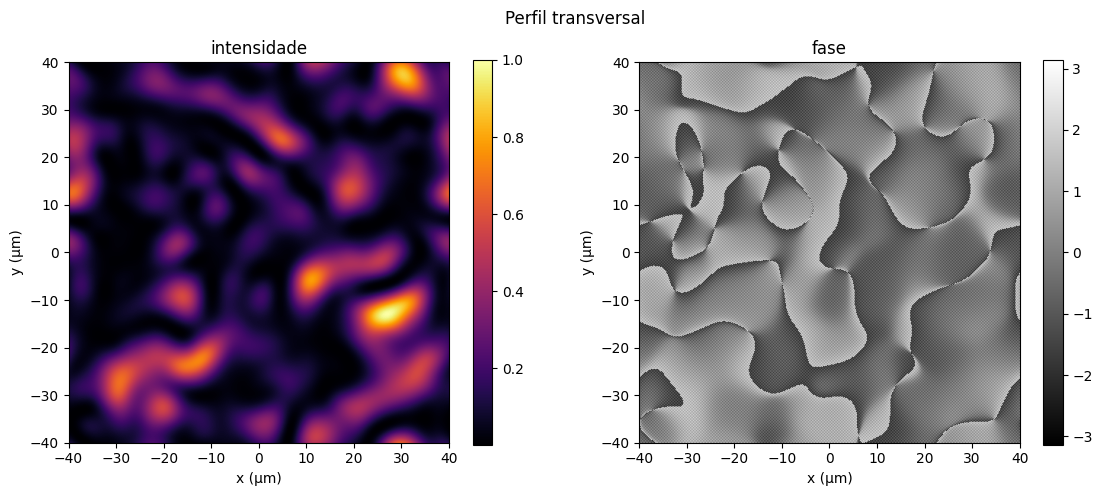

In [5]:
# exibe as imagens geradas em linha
%matplotlib inline

# cria a figura com dois subplots de tamanho (13.5, 5.0) em inches
fig, ax = plt.subplots(1, 2, figsize = (13.5, 5.0));
fig.suptitle('Perfil transversal')

# criação de gráfico no primeiro quadro
grafico = ax[0].imshow(
    np.abs(S) ** 2,                 # com valores de intensidade
    # com valores dos eixos
    extent = [
        x[0], x[-1],                # entre (x[0], x[-1])
        y[0], y[-1]                 # entre (y[0], y[-1])
    ],
    cmap = 'inferno'                # com mapa de cores 'inferno'
)
# insere a barra de cores da intensidade na figura
fig.colorbar(grafico);
# insere o título do primeiro quadro
ax[0].set_title('intensidade');
# renomeia os eixos do primeiro quadro
ax[0].set_xlabel('x (μm)');
ax[0].set_ylabel('y (μm)');

# criação de gráfico no segundo quadro
grafico = ax[1].imshow(
    np.angle(S),                    # com valores de fase
    # com valores dos eixos
    extent = [
        x[0], x[-1],                # entre (x[0], x[-1])
        y[0], y[-1]                 # entre (y[0], y[-1])
    ],
    cmap = 'gray'                   # com mapa de cores 'gray'
)
# inserir a barra de cores da fase na figura
fig.colorbar(grafico);
# insere o título do segundo quadro
ax[1].set_title('fase');
# renomeia os eixos do segundo quadro
ax[1].set_xlabel('x (μm)');
ax[1].set_ylabel('y (μm)');